In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


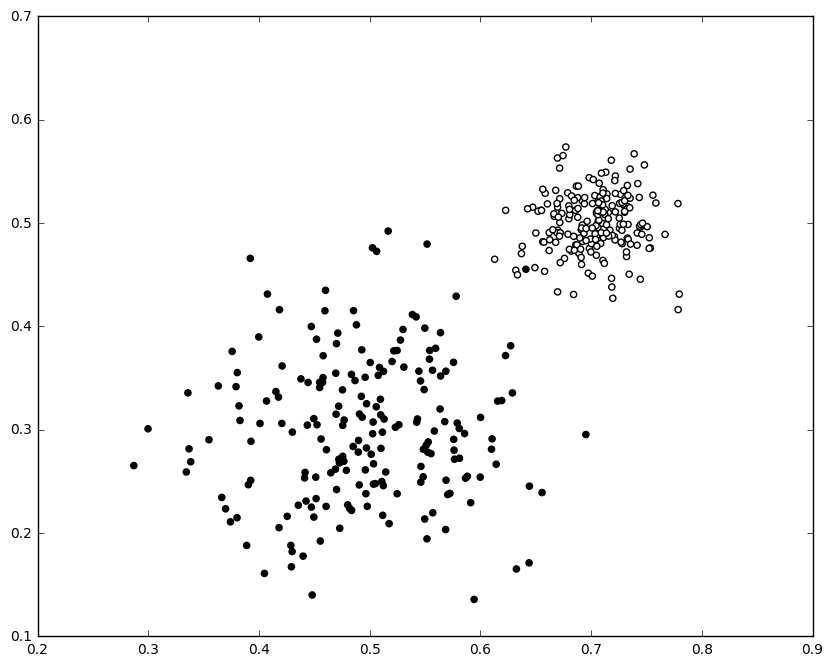

In [176]:
K = 2
N = 200

X = np.vstack((np.random.normal(loc=[0.5, 0.3], scale = 0.07, size = (N, 2)),
               np.random.normal(loc=[0.7, 0.5], scale = 0.03, size = (N, 2))))
y = np.hstack((-1 * np.ones(N), np.ones(N)))

train_test_split = np.array(random.sample(range(N * 2), N))

X_train = X[train_test_split, :]
y_train = y[train_test_split]
    
X_test = X[-train_test_split, :]
y_test = y[-train_test_split]

plt.scatter(X[:, 0], X[:, 1], c = y)

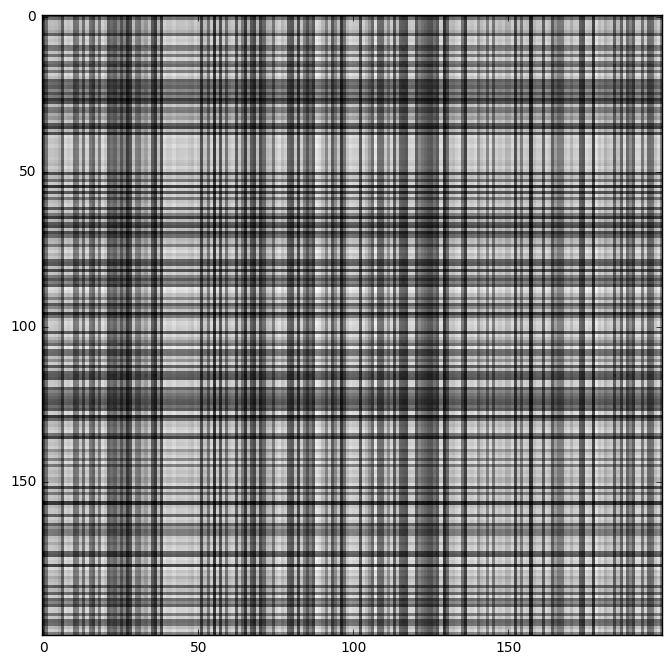

In [177]:
svm_kernel = lambda X, Y: (np.dot(X, Y.T) + 1.0) ** 2

plt.imshow(svm_kernel(X_train, X_train))

     pcost       dcost       gap    pres   dres
 0: -2.6977e+01 -7.0838e+01  7e+02  2e+01  2e+00
 1: -3.8774e+01 -8.7708e+01  4e+02  1e+01  1e+00
 2: -5.9989e+01 -1.1278e+02  2e+02  4e+00  4e-01
 3: -7.1630e+01 -1.2376e+02  2e+02  4e+00  4e-01
 4: -1.1683e+02 -1.4479e+02  1e+02  1e+00  1e-01
 5: -1.2076e+02 -1.2276e+02  8e+00  1e-01  1e-02
 6: -1.2120e+02 -1.2135e+02  3e-01  2e-03  2e-04
 7: -1.2133e+02 -1.2133e+02  3e-03  2e-05  2e-06
 8: -1.2133e+02 -1.2133e+02  3e-05  2e-07  2e-08
 9: -1.2133e+02 -1.2133e+02  3e-07  2e-09  2e-10
Optimal solution found.
beta0 = -16.0482590057


(array([ 197.,    0.,    1.,    0.,    0.,    0.,    0.,    1.,    0.,    1.]),
 array([ -1.20629218e-11,   1.21328271e+01,   2.42656543e+01,
          3.63984814e+01,   4.85313086e+01,   6.06641357e+01,
          7.27969628e+01,   8.49297900e+01,   9.70626171e+01,
          1.09195444e+02,   1.21328271e+02]),
 <a list of 10 Patch objects>)

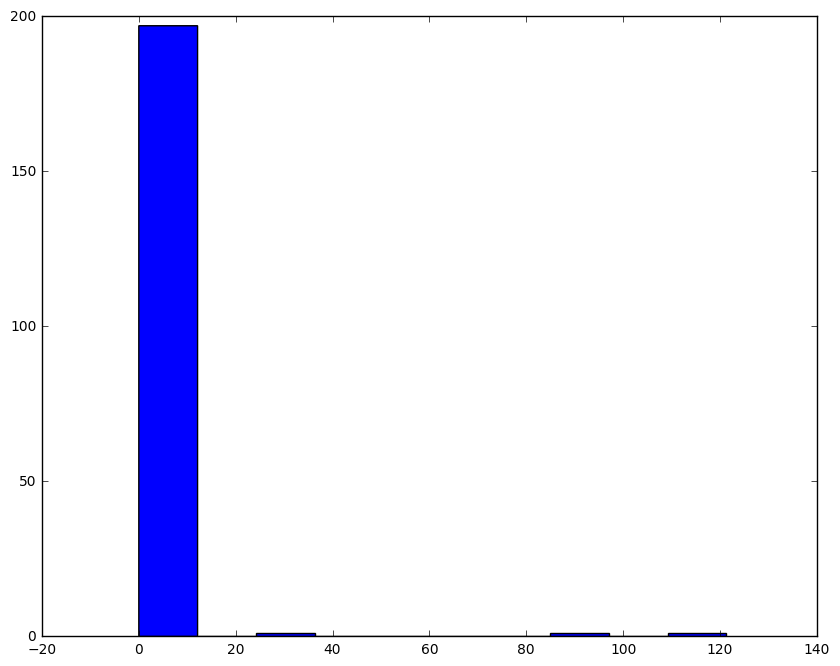

In [178]:
# The Elements of Statistical Learning: Data Mining, Inference, and Prediction, 2nd ed
# Trevor Hastie, Robert Tibshirani, Jerome Friedman
# https://statweb.stanford.edu/~tibs/ElemStatLearn/
# pp. 420, 423

# http://cs229.stanford.edu/notes/cs229-notes3.pdf

# L = sum(alpha) - 1/2 * sum_i(sum_j(alpha_i * alpha_j * y_i * y_j * kernel(x_i, x_j)))
# subject to sum_i(alpha_i * y_i) = 0
#            alpha > 0

# http://cvxopt.org/userguide/coneprog.html#quadratic-programming
# minimize 1/2 * x.T * P * x + q.T * x
# subject to G * x < h
#            A * x = b

def svm_train(X, y):   
    P = cvxopt.matrix(svm_kernel(X, X) * np.outer(y, y))
    q = cvxopt.matrix(-np.ones(N))
    G = cvxopt.matrix(-1.0 * np.eye(N))
    h = cvxopt.matrix(0.0, (N, 1))
    A = cvxopt.matrix(y_train, (1, N))
    b = cvxopt.matrix(0.0)

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    alpha = np.array(solution["x"]).reshape(-1)
    
    beta = np.sum(alpha * y_train * svm_kernel(X_train, X_train).T, axis = 1)
    beta0 = -(np.max(beta[y_train > 0]) + np.min(beta[y_train < 0])) / 2.
    
    return (alpha, beta0)

(alpha, beta0) = svm_train(X_train, y_train)

print("beta0 =", beta0)
plt.hist(alpha)

(array([ 10.,  20.,  21.,  28.,   9.,   5.,   5.,  22.,  63.,  17.]),
 array([ -7.80856547e+00,  -6.24685238e+00,  -4.68513928e+00,
         -3.12342619e+00,  -1.56171309e+00,   1.77635684e-15,
          1.56171309e+00,   3.12342619e+00,   4.68513928e+00,
          6.24685238e+00,   7.80856547e+00]),
 <a list of 10 Patch objects>)

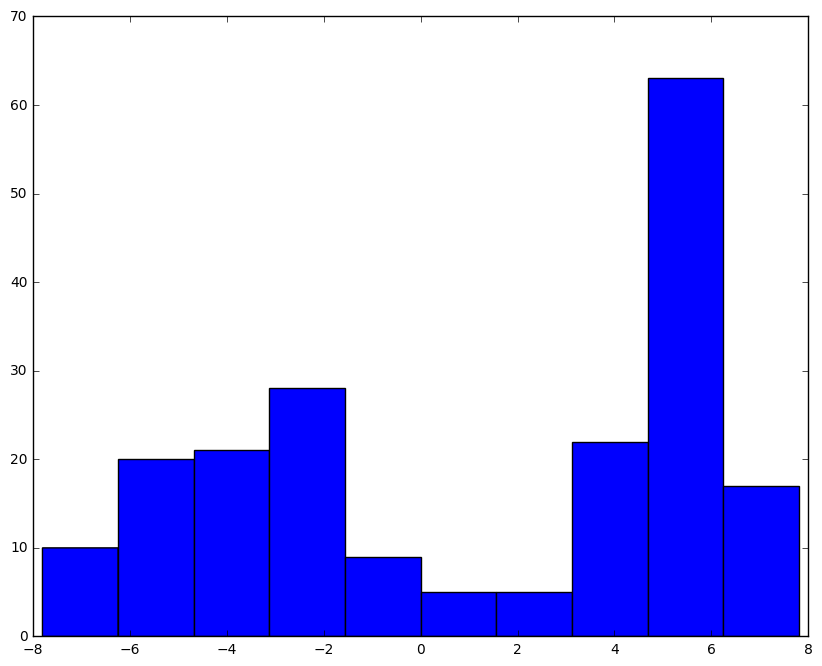

In [179]:
plt.hist(np.sum(alpha * y_train * svm_kernel(X_train, X_train).T, axis = 1) + beta0)

In [180]:
def svm_predict(X):  
    return np.sign(np.sum(alpha * y_train * svm_kernel(X_train, X).T, axis = 1) + beta0)

print("accuracy on training set =", (svm_predict(X_train) == y_train).mean())
print("accuracy on test set =", (svm_predict(X_test) == y_test).mean())


accuracy on training set = 0.975
accuracy on test set = 0.985


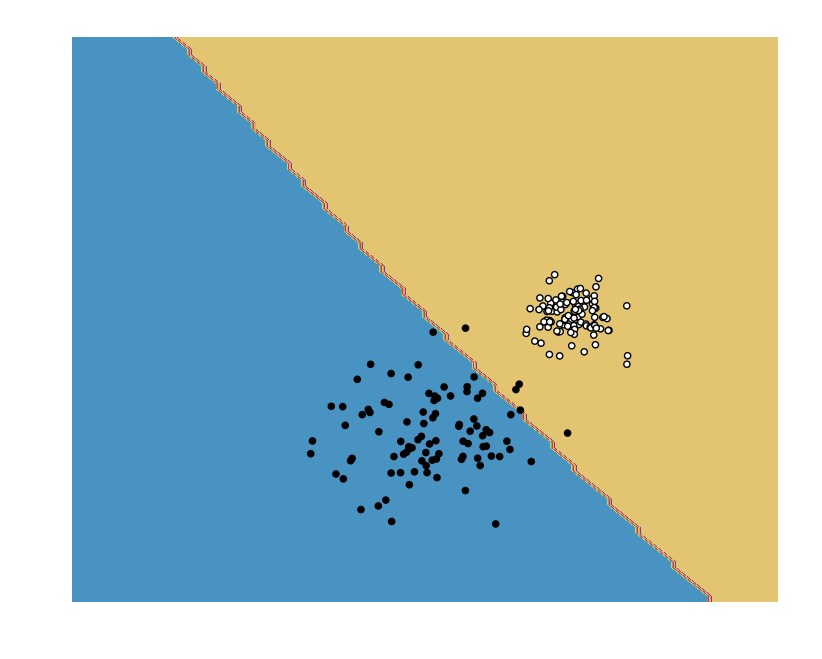

In [181]:
xx, yy = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
X_boundary = np.c_[xx.ravel(), yy.ravel()]
y_boundary = 2 * svm_predict(X_boundary) + 1

plt.contourf(xx, yy, y_boundary.reshape(xx.shape), cmap=plt.cm.Paired)
plt.axis('off')
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)